In [947]:
from __future__ import print_function
import numpy as np
from collections import Counter
import itertools
from tqdm import tqdm

enable_print = 0


def print(*args, **kwargs):
    if enable_print:
        return __builtins__.print(*args, **kwargs)


enable_print = 1  #toggle to turn off printing of logs


class agent(object):
    #-----------------------------------------------------------------------------------------------#
    '''
    Agent Generation Mechanism. Extracts node attribute information from graph structure

    PARMS:
        node_number: int, assigning variable name to agents. Just use index position
        G: A networkx graph structure; G(V,E)
        env: an environment. Environment and Agents will communicate and pass back and forth state information
        seed: int, used for random number generator

                                env(G(V,E), Agents(G(V,E), env))
                                agents operate within the environment class.

    RETURNS:
        Graph with node attributes set
    '''

    #-----------------------------------------------------------------------------------------------#
    def __init__(self, node_number, G, env, seed=1, enable_print=1):
        self.node_number = node_number
        self.nodeData = env.nodeData                                 #key (node number): (strategy, p_act, neighbors, degree)
        self.seed = np.random.seed(seed)
        self.letters = {
            'letters_initial': [],
            'letters_stolen': [],
            'letters_received': []
        }
        self.target_word = []
        self.l_union_vi = []
        self.letters_needed = []
        self.corpus = []
        self.actions_taken = 0 
        self.words_formed = 0

    def _merge_letters(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        Merge all letters in agent.letters 
        This returns a set of all letters, including non-unique entries
        '''
        #-----------------------------------------------------------------------------------------------#
        self.l_union_vi = list(itertools.chain.from_iterable(self.letters.values()))

    def _find_needed_letters(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        Find the letters needed to complete a target word. Calc difference between two independent sets.
        '''
        #-----------------------------------------------------------------------------------------------#
        self._merge_letters()
        self.letters_needed = np.setdiff1d(self.target_word, self.l_union_vi)
        
    def _update_state_info(self,env): 
        self._merge_letters() #Remerge and update lunion
        self._find_needed_letters() #re-find needed letters
        env.historical_states[env.time] = env.current_state
        env.current_state[self.node_number] = self.letters
        env.time += 1
        self.actions_taken += 1
        print('state info updated')

    def get_init_hand(self, env):
        #-----------------------------------------------------------------------------------------------#
        '''
        Get initial hand prior to game start. 
        t=0 at this point. We randomly choose letters over the alphabet uniformly.
        Assign back to dict in environment containing local state information.
        '''
        #-----------------------------------------------------------------------------------------------#
        self.letters['letters_initial'] = np.random.choice(
            env.alphabet, 5)  #k is the length of each element in corpus
        env.current_state[self.node_number] = self.letters

    def get_target_word(self, env):
        #-----------------------------------------------------------------------------------------------#
        '''
        After c^possible is instantiated and set by the env, we use an augmented form of hamming distance 
        to determine a target word that is the closest to us. 
        '''
        #-----------------------------------------------------------------------------------------------#
        matches = []
        for i in self.corpus:
            matches.append(
                len(self.l_union_vi) -
                len([j for j in self.l_union_vi if j in i]))
        tword = self.corpus[np.argmin(matches)]
        self.corpus.remove(tword)
        self.target_word = [i for i in tword]
        self._find_needed_letters()

    def _agent_form_word(self,env):
        #-----------------------------------------------------------------------------------------------#
        '''
        Need to update to remove letters from Lrecieved and Lstolen if used to form a word
        '''
        #-----------------------------------------------------------------------------------------------#
        assert env.time < env.time_max, 'Maximum time allowed has been reached'
        if len(self.letters_needed) == 0:
            env.words_formed.append(("".join(self.target_word),self.node_number)) #global counter
            self.get_target_word(env) #get new target word
        else:
            print('unable to form word. Need additional letters.')
        self._update_state_info(env)
        
        

    def _agent_steal_letter(self,env):
        #-----------------------------------------------------------------------------------------------#
        '''
        Find letters needed to complete the target word. 
        Randomly selects a single letter.
        Finds neighbors of current node and scans their union set to see if this letter exists. If it does, steals letter.
        Update env.current state and pop current state to historical state. Increment timer
        Need to update so a letter stolen from non init dist is depleted
        '''
        #-----------------------------------------------------------------------------------------------#
        assert env.time < env.time_max, 'Maximum time allowed has been reached'
        print('action to node: {}'.format(self.node_number))
        print('taking action: steal letter')
        neighbors = self.nodeData[self.node_number][2]
        print('available neighbors: {}'.format(neighbors))
        letters_needed = self.letters_needed
        print(f'letters needed to reach the target {letters_needed}')
        if len(letters_needed) != 0: 
            choose_letter_to_steal = np.random.choice(letters_needed)
        else: choose_letter_to_steal = None
        
        if choose_letter_to_steal != None:
            print(f'randomly selecting letter to steal: {choose_letter_to_steal}')
            for k, v in env.agents.items():
                if k in neighbors:
                    if choose_letter_to_steal in v.l_union_vi:
                        print(
                            f'neighbor {env.agents[k].node_number} : neighbor hand {env.agents[k].l_union_vi}'
                        )
                        self.letters['letters_stolen'].append(
                            choose_letter_to_steal)  #update local state
                        print('letter successfully stolen from node {}'.format(v))
                        break
        else:
            print('unable to steal the chosen letter from k-hop neighbors')

        self._update_state_info(env)

    def _agent_pass_letter(self,env):
        #-----------------------------------------------------------------------------------------------#
        '''
        Need to update so a letter passed from non init dist is depleted
        '''
        #-----------------------------------------------------------------------------------------------#
        assert env.time < env.time_max, 'Maximum time allowed has been reached'
        print('action to node: {}'.format(self.node_number))
        print('taking action: pass letter')
        neighbors = self.nodeData[self.node_number][2]
        print('available neighbors: {}'.format(neighbors))
        choose_letter_to_pass = np.random.choice(self.letters['letters_initial'])
        if choose_letter_to_pass != None:
            print(f'randomly selecting letter to pass: {choose_letter_to_pass}')
            for k, v in env.agents.items():
                if k in neighbors:
                    if choose_letter_to_pass not in v.l_union_vi:
                        print(
                            f'neighbor {env.agents[k].node_number} : neighbor hand {env.agents[k].l_union_vi}'
                        )
                        env.agents[k].letters['letters_received'].append(
                            choose_letter_to_pass)  #update local state
                        print('letter successfully passed from node {} to node {}'.format(self.node_number, v))
                        break
        else:
            print('unable to steal the chosen letter from k-hop neighbors')

        self._update_state_info(env)

    def _agent_think(self,env):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        assert env.time < env.time_max, 'Maximum time allowed has been reached'
        print('action to node: {}'.format(self.node_number))
        print('taking action: think')
        self._update_state_info(env)

    def take_action(self,env):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        n_Data = self.nodeData[self.node_number]
        node = self.node_number
        strategy = n_Data[0]
        p_act = n_Data[1]
        neighbors = n_Data[2]
        action_sampling = np.random.choice(env.action_space, p=p_act)

        if action_sampling == env.action_space[0]:  #form_word
            self._agent_form_word(env)
        if action_sampling == env.action_space[1]:  #steal_letter
            self._agent_steal_letter(env)
        if action_sampling == env.action_space[2]:  #pass_letter
            self._agent_pass_letter(env)
        if action_sampling == env.action_space[3]:  #think / null action
            self._agent_think(env)

In [948]:
from utils.helpers import possible_words


class environment(object):
    #-----------------------------------------------------------------------------------------------#
    '''
    Agent Generation Mechanism. Extracts node attribute information from graph structure

    PARMS:
        G: A networkx graph structure; G(V,E)

    '''
    #-----------------------------------------------------------------------------------------------#
    def __init__(self, G, t_max):

        self.G = G
        self.nodes = G.nodes
        self.edges = G.edges
        self.agents = []
        self.action_space = [
            'form_word', 'steal_letter', 'pass_letter', 'think'
        ]
        self.l_init_union = []
        self.corpus = np.loadtxt(fname='txt/five_letter_words.txt',
                                 dtype='str')
        self.corpus_possible = []
        self.alphabet = np.loadtxt(fname='txt/alphabet_english.txt',
                                   dtype='str')
        self.nodeData = {}
        self.current_state = {}  #at t
        self.historical_states = {}  #pop from current state at t+1
        self.words_formed = []  #by player
        self.time = 0
        self.time_max = t_max

    def _getnodeData(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        for i, j in enumerate(self.G.nodes):
            self.nodeData[i] = (self.G.nodes[i]['atts'][0],
                                self.G.nodes[i]['atts'][1],
                                [j for j in self.G.neighbors(i)],
                                self.G.degree(i))

    def _find_cand_words(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        l_init_union = [[i for l in d.values() for i in l]
                        for d in self.current_state.values()
                        ]  #Compute Union over all init letter dist
        self.l_init_union = list(
            itertools.chain(*l_init_union))  #flatten to 1d array

        self.corpus_possible = possible_words(
            self.corpus, self.l_init_union)  #find C^possible
        
        for i in self.agents:
            self.agents[i].corpus = self.corpus_possible

        print(
            f'total corpus size {len(self.corpus)}, total count of possible words {len(self.corpus_possible)}'
        )

    def _push_to_historical(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        self.historical_states[self.time] = self.current_state

    def _set_init_targets(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        [
            self.agents[i].get_target_word(self)
            for i in range(len(self.G.nodes))
        ]
        self._push_to_historical()  #push to historical states dict
        self.time += 1  #increment time counter

    def set_agents(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        #-------------------------------------------------
        #Create Agents
        #-------------------------------------------------
        agents = {}
        num_nodes = len(self.G.nodes)
        agent_names = [str(i) for i in range(len(self.G.nodes))]
        for i, j in enumerate(agent_names):
            agents[i] = agent(node_number=i, G=self.G, env=self)
        #-------------------------------------------------
        #Get init hand and pass back data to env.current_state
        #-------------------------------------------------
        print('agents passed into env')
        self.agents = agents

        [j.get_init_hand(self) for i, j in self.agents.items()
         ]  #-> L_init(agent) & env.current_state
        print('all agents assigned letters_initial')

        print('searching for candidate words C^possible in C')
        self._find_cand_words(
        )  #Find Candidate Words - C^Possible, given init letter distr

        print('agents passed into env')
        print('init target words set locally. Time counter incremented by 1')
        self._set_init_targets()  #Set initial target word

    def set_env(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        assert len(self.alphabet) == 26, 'Alphabet size mismatch'
        self._getnodeData()
        self.set_agents()
        print('Environment set - > Graph Created. Node attributes assigned.')
        
    def output_logs(self):
        pass
    
    def play(self):
        while self.time < self.time_max:
            for j in range(0, len(self.agents)):
                self.agents[j].take_action(self)
        

    def reset_env(self):
        #-----------------------------------------------------------------------------------------------#
        '''
        '''
        #-----------------------------------------------------------------------------------------------#
        pass

  node       strat                 p_act  neighbors degree
0   v0     selfish  [0.1, 0.4, 0.2, 0.3]        [4]      1
1   v1  altruistic  [0.1, 0.2, 0.4, 0.3]     [2, 4]      2
2   v2  altruistic  [0.1, 0.2, 0.4, 0.3]  [1, 3, 4]      3
3   v3  altruistic  [0.1, 0.2, 0.4, 0.3]        [2]      1
4   v4  altruistic  [0.1, 0.2, 0.4, 0.3]  [0, 1, 2]      3


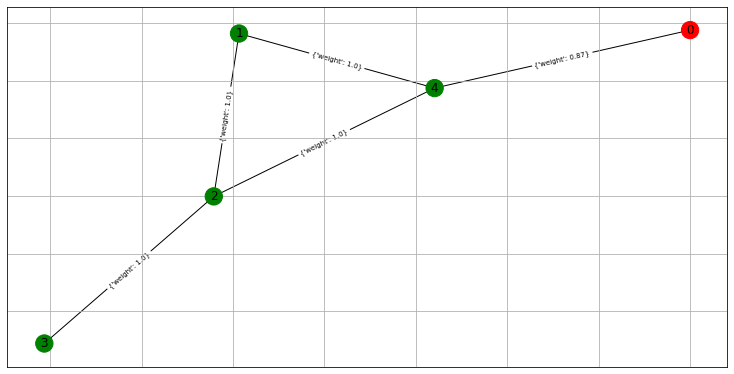

agents passed into env
all agents assigned letters_initial
searching for candidate words C^possible in C
total corpus size 5757, total count of possible words 605
agents passed into env
init target words set locally. Time counter incremented by 1
Environment set - > Graph Created. Node attributes assigned.


  0%|          | 0/10000 [00:00<?, ?it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
neighbor 2 : neighbor hand ['b', 'm', 'h', 'n', 'g']
letter successfully passed from node 1 to node <__main__.agent object at 0x0000024C8B102CC0>
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target ['i' 'o']
randomly selecting letter to steal: i
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
unable to form word. Need additional letters.
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
neighbor 1 : neighbor hand ['l', 'f', 'p', 'a', 'q']
letter successfully passed from node 2 to node <__main__.agent object at 0x0000024C

  0%|          | 6/10000 [00:00<02:56, 56.76it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target ['a' 'g' 'n']
randomly selecting letter to steal: g
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
neighbor 2 : neighbor hand ['b', 'm', 'h', 'n', 'g', 'f', 's']
letter successfully passed from node 1 to node <__main__.agent object at 0x0000024C8B102CC0>
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
neighbor 3 : neighbor hand ['z', 's', 'u', 'f', 's', 'n']
letter successfully passed from node 2 to node <__main__.agent object at 0x0000024C8B102C88>
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target ['a' 'g' 'l' 'o']
randomly selecting letter to steal: o
state info updated
action to node: 4
taking action: think
state info updated
action to node: 

  0%|          | 12/10000 [00:00<03:05, 53.71it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
neighbor 3 : neighbor hand ['z', 's', 'u', 'f', 's', 'n', 'b']
letter successfully passed from node 2 to node <__main__.agent object at 0x0000024C8B102C88>
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
neighbor 0 : neighbor hand ['f', 'l', 'm', 'i', 'j', 's', 'o', 'k']
letter successfully passed from node 4 to node <__main__.agent object at 0x0000024C8B102E10>


  0%|          | 17/10000 [00:00<03:17, 50.52it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target ['a' 'g' 'n']
randomly selecting letter to steal: g
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
neighbor 4 : neighbor hand ['u', 'l', 'k', 'o', 's', 'h', 'f', 'b']
letter successfully passed from node 1 to node <__main__.agent object at 0x0000024C8B102FD0>
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
neighbor 1 : neighbor hand ['l', 'f', 'p', 'a', 'q', 's', 'm', 'b', 'n', 'g', 'u']
letter successfully passed from node 4 to node <__main__.agent object at 0x0000024C8B102EF0>
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target ['a

  0%|          | 22/10000 [00:00<03:24, 48.79it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target ['g' 'n']
randomly selecting letter to steal: g
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
neighbor 4 : neighbor hand ['u', 'l', 'k', 'o', 's', 'h', 'f', 'b', 'a', 'i', 'n']
letter successfully passed from node 2 to node <__main__.agent object at 0x0000024C8B102FD0>
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target ['g' 'n']
randomly selecting letter to steal: n
neighbor 4 : neighbor hand ['u', 'l', 'k', 'o', 's', 'h', 'f', 'b', 'a', 'i', 'n', 'm']
letter successfully stolen from nod

  0%|          | 29/10000 [00:00<03:11, 52.14it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target ['g']
randomly selecting letter to steal: g
neighbor 4 : neighbor hand ['u', 'l', 'k', 'o', 's', 'h', 'f', 'b', 'a', 'i', 'n', 'm', 'q', 'g']
letter successfully stolen from node <__main__.agent object at 0x0000024C8B102FD0>
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
neighbor 2 : neighbor hand ['b', 'm'

  0%|          | 34/10000 [00:00<03:23, 48.96it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updat

  0%|          | 39/10000 [00:00<03:26, 48.17it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
state info updated
action to node: 0
taking action:

  0%|          | 46/10000 [00:00<03:09, 52.57it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
a

  1%|          | 52/10000 [00:00<03:03, 54.35it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the t

  1%|          | 58/10000 [00:01<03:00, 55.05it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen 

  1%|          | 64/10000 [00:01<03:01, 54.79it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking

  1%|          | 70/10000 [00:01<03:03, 54.17it/s]

action to node: 0
taking action: think
state info updated
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: think
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: i
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pa

  1%|          | 76/10000 [00:01<03:01, 54.77it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info u

  1%|          | 82/10000 [00:01<03:05, 53.43it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info upd

  1%|          | 88/10000 [00:01<03:04, 53.66it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from 

  1%|          | 94/10000 [00:01<03:15, 50.56it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass lett

  1%|          | 101/10000 [00:01<03:04, 53.67it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target [

  1%|          | 107/10000 [00:02<03:01, 54.56it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to 

  1%|          | 113/10000 [00:02<03:08, 52.34it/s]

state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
t

  1%|          | 119/10000 [00:02<03:17, 50.11it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: i
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
sta

  1%|▏         | 125/10000 [00:02<03:21, 49.01it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available n

  1%|▏         | 131/10000 [00:02<03:15, 50.46it/s]

action to node: 0
taking action: think
state info updated
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
state info updated
state info updated
action to node: 1
taking action: think
state info up

  1%|▏         | 137/10000 [00:02<03:13, 51.00it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: think
state info update

  1%|▏         | 143/10000 [00:02<03:09, 52.06it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated


  1%|▏         | 149/10000 [00:02<03:10, 51.60it/s]

state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
u

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated


  2%|▏         | 180/10000 [00:03<03:12, 51.12it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info upd

  2%|▏         | 186/10000 [00:03<03:15, 50.18it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: think
state info updated
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen le

  2%|▏         | 192/10000 [00:03<03:30, 46.56it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to 

  2%|▏         | 197/10000 [00:03<03:33, 46.00it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: steal lett

  2%|▏         | 202/10000 [00:03<03:38, 44.89it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to

  2%|▏         | 207/10000 [00:04<03:37, 44.97it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: think
st

  2%|▏         | 213/10000 [00:04<03:23, 48.19it/s]

state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter 

  2%|▏         | 219/10000 [00:04<03:14, 50.35it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
ta

  2%|▏         | 225/10000 [00:04<03:20, 48.70it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
una

  2%|▏         | 230/10000 [00:04<03:47, 42.94it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking acti

  2%|▏         | 235/10000 [00:04<03:47, 42.91it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 1
taking action: think
state info updated
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1

  2%|▏         | 242/10000 [00:04<03:27, 47.01it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
availa

  2%|▏         | 248/10000 [00:04<03:22, 48.25it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated


  3%|▎         | 274/10000 [00:05<02:51, 56.55it/s]

state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: think
state info updated
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info

  3%|▎         | 280/10000 [00:05<02:56, 55.06it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randoml

  3%|▎         | 286/10000 [00:05<03:04, 52.78it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available nei

  3%|▎         | 292/10000 [00:05<03:06, 52.09it/s]

state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: s

  3%|▎         | 299/10000 [00:05<02:53, 55.78it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pas

  3%|▎         | 305/10000 [00:05<02:55, 55.30it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly select

  3%|▎         | 311/10000 [00:05<02:54, 55.57it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
state info updated
action to node: 3
taking action: pass letter
available nei

  3%|▎         | 317/10000 [00:06<02:51, 56.39it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking act

  3%|▎         | 323/10000 [00:06<02:50, 56.66it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
ra

  3%|▎         | 329/10000 [00:06<02:50, 56.69it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
ra

  3%|▎         | 335/10000 [00:06<03:00, 53.53it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to

  3%|▎         | 341/10000 [00:06<02:59, 53.87it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated


  4%|▎         | 366/10000 [00:06<02:57, 54.22it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
una

  4%|▎         | 373/10000 [00:07<02:47, 57.34it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to stea

  4%|▍         | 380/10000 [00:07<02:48, 56.98it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action

  4%|▍         | 386/10000 [00:07<02:47, 57.56it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info upda

  4%|▍         | 392/10000 [00:07<02:53, 55.42it/s]

state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action:

  4%|▍         | 398/10000 [00:07<02:55, 54.75it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action:

  4%|▍         | 404/10000 [00:07<03:01, 52.99it/s]

state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to n

  4%|▍         | 410/10000 [00:07<02:57, 54.07it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info u

  4%|▍         | 417/10000 [00:07<02:47, 57.08it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target

  4%|▍         | 423/10000 [00:08<02:51, 55.87it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: think
state info updated
action to n

  4%|▍         | 430/10000 [00:08<02:43, 58.62it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 3
taking action: think
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
act

  4%|▍         | 437/10000 [00:08<02:40, 59.47it/s]

state info updated
action to node: 1
taking action: think
state info updated
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: steal letter
availabl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to

  5%|▍         | 464/10000 [00:08<02:37, 60.65it/s]

action to node: 0
taking action: think
state info updated
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
a

  5%|▍         | 471/10000 [00:08<02:31, 62.72it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen 

  5%|▍         | 478/10000 [00:08<02:42, 58.47it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
state info updated
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed t

  5%|▍         | 485/10000 [00:09<02:38, 59.98it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []


  5%|▍         | 492/10000 [00:09<02:34, 61.56it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
sta

  5%|▍         | 499/10000 [00:09<02:46, 57.20it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to n

  5%|▌         | 505/10000 [00:09<02:45, 57.23it/s]

state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly sel

  5%|▌         | 511/10000 [00:09<02:50, 55.50it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: think
state info updated
state info updated
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking actio

  5%|▌         | 517/10000 [00:09<02:52, 54.95it/s]

state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-

  5%|▌         | 523/10000 [00:09<02:50, 55.64it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target 

  5%|▌         | 530/10000 [00:09<02:44, 57.43it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
una

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
state info updated
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated


  6%|▌         | 554/10000 [00:10<02:48, 55.93it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
state 

  6%|▌         | 560/10000 [00:10<02:53, 54.35it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter

  6%|▌         | 566/10000 [00:10<02:50, 55.35it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
state info updated
action to node: 1
taking act

  6%|▌         | 573/10000 [00:10<02:40, 58.66it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available ne

  6%|▌         | 579/10000 [00:10<02:50, 55.20it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking ac

  6%|▌         | 585/10000 [00:10<02:49, 55.50it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: i
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to

  6%|▌         | 592/10000 [00:10<02:43, 57.61it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors


  6%|▌         | 599/10000 [00:11<02:44, 57.31it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
t

  6%|▌         | 605/10000 [00:11<02:46, 56.50it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: think
state in

  6%|▌         | 612/10000 [00:11<02:40, 58.65it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: i
state info updated
ac

  6%|▌         | 619/10000 [00:11<02:38, 59.20it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: think
state info updated
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
takin

  6%|▋         | 625/10000 [00:11<02:38, 59.31it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors:

  6%|▋         | 631/10000 [00:11<02:42, 57.51it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available ne

  6%|▋         | 637/10000 [00:11<02:56, 53.18it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated


  7%|▋         | 664/10000 [00:12<02:48, 55.26it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to ste

  7%|▋         | 670/10000 [00:12<02:46, 56.01it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
state info updated
action to node: 3
taking action: think
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target 

  7%|▋         | 676/10000 [00:12<02:49, 55.00it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated

  7%|▋         | 682/10000 [00:12<02:46, 55.98it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: i
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the ch

  7%|▋         | 689/10000 [00:12<02:40, 57.97it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
state info updated
action to node: 3
taking action: pass letter
availab

  7%|▋         | 695/10000 [00:12<02:42, 57.44it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: steal letter


  7%|▋         | 701/10000 [00:12<02:42, 57.07it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info upd

  7%|▋         | 708/10000 [00:12<02:37, 58.94it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters neede

  7%|▋         | 714/10000 [00:13<02:44, 56.46it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighb

  7%|▋         | 721/10000 [00:13<02:38, 58.48it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighb

 10%|█         | 1022/10000 [00:18<02:46, 53.80it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
act

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to no

 11%|█         | 1059/10000 [00:19<02:47, 53.47it/s]

state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1,

 11%|█         | 1065/10000 [00:19<02:46, 53.54it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updat

 11%|█         | 1071/10000 [00:19<02:49, 52.75it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: b
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter 

 11%|█         | 1078/10000 [00:19<02:44, 54.35it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
state info updated
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter

 11%|█         | 1084/10000 [00:19<02:46, 53.43it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
ac

 11%|█         | 1091/10000 [00:19<02:42, 54.99it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
state info updated
action to node: 3
taking action: steal le

 11%|█         | 1097/10000 [00:19<02:41, 55.05it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
av

 11%|█         | 1103/10000 [00:19<02:38, 56.17it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: i
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting let

 11%|█         | 1110/10000 [00:19<02:31, 58.70it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
state info updated
state info updated
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: a
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]


 11%|█         | 1116/10000 [00:20<02:33, 57.94it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: think


 11%|█         | 1122/10000 [00:20<02:34, 57.41it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: u
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: u
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to st

 12%|█▏        | 1153/10000 [00:20<02:37, 56.22it/s]

state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pas

 12%|█▏        | 1159/10000 [00:20<02:43, 54.10it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: o
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass:

 12%|█▏        | 1166/10000 [00:20<02:34, 57.24it/s]

state info updated
action to node: 1
taking action: think
state info updated
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: l
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: f
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: l
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting 

 12%|█▏        | 1172/10000 [00:21<02:37, 56.13it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: p
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: pass letter
availab

 12%|█▏        | 1178/10000 [00:21<02:37, 56.00it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: z
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 

 12%|█▏        | 1184/10000 [00:21<02:39, 55.30it/s]

action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: m
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: f
state info updated
action to node: 1
taking ac

 12%|█▏        | 1190/10000 [00:21<02:40, 54.81it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: steal letter
available neighbors: [2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: n
state info u

 12%|█▏        | 1196/10000 [00:21<02:45, 53.18it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: g
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 0
taking action: pass letter
available neighbors: [4]
randomly selecting letter to pass: j
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: think
state info upda

 12%|█▏        | 1202/10000 [00:21<02:40, 54.80it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: steal letter
available neighbors: [2, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: k
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: l
state info updated
action to node: 2
taking action: think
state info updated
state info updated
action to node: 4
taking action: think
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the t

 12%|█▏        | 1208/10000 [00:21<02:37, 55.68it/s]

action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: steal letter
available neighbors: [1, 3, 4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 3
taking action: think
state info updated
state info updated
action to node: 0
taking action: think
state info updated
action to node: 1
taking action: think
state info updated
action to node: 2
taking action: think
state info updated
action to node: 3
taking action: pass letter
available neighbors: [2]
randomly selecting letter to pass: s
state info updated
action to node: 4
taking action: steal letter
available neighbors: [0, 1, 2]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
acti

 12%|█▏        | 1214/10000 [00:21<02:35, 56.63it/s]

action to node: 0
taking action: think
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: f
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: m
state info updated
action to node: 3
taking action: think
state info updated
action to node: 4
taking action: pass letter
available neighbors: [0, 1, 2]
randomly selecting letter to pass: s
state info updated
action to node: 0
taking action: steal letter
available neighbors: [4]
letters needed to reach the target []
unable to steal the chosen letter from k-hop neighbors
state info updated
action to node: 1
taking action: pass letter
available neighbors: [2, 4]
randomly selecting letter to pass: q
state info updated
action to node: 2
taking action: pass letter
available neighbors: [1, 3, 4]
randomly selecting letter to pass: h
state info updated
action to node: 3
taking action: think
state in

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [954]:
import os
from utils.graphinit import Network

#Graph Generation
num_nodes = 5
prob_edges = 0.5

#Node Attributes
pr_selfish = 0.5
pr_altrustic = 1 - pr_selfish
p_star = 0.20

G, table = Network(num_nodes, prob_edges, pr_selfish,
                  p_star).make_random_graph(plot=True, print_table=True)


env = environment(G, t_max= 500)
env.set_env()
env.play()

In [714]:
#!pip install dash
import dash
import dash_table
import pandas as pd

df = pd.DataFrame.from_dict(env.current_state)

df.T

,letters_initial,letters_received,letters_stolen
0,"[f, l, m, i, j]",[],[]
1,"[l, f, p, a, q]",[],[]
2,"[b, m, h, n, g]",[],[]
3,"[z, s, u, f, s]",[],[]
4,"[u, l, k, o, s]",[],[]
5,"[e, x, x, j, r]",[],[]
6,"[x, a, w, n, j]",[],[]
7,"[j, h, w, z, b]",[],[]
8,"[a, r, i, y, n]",[],[]
9,"[t, p, k, z, i]",[],[]
